# RESNET50

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import warnings
import seaborn as sns
import cv2 as cv2
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall
from sklearn.metrics import confusion_matrix, f1_score, classification_report
warnings.filterwarnings('ignore')
tf.keras.backend.clear_session()

## Load Images

In [6]:
df = pd.read_csv('train.csv')
df.head()

,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0


In [7]:
df["id_code"] = df["id_code"].astype(str) + ".png"
label_map = dict(zip(df["id_code"], df["diagnosis"]))
dataset_path = 'colored_images'
X = []
y = []


In [8]:
df.head()

,id_code,diagnosis
0,000c1434d8d7.png,2
1,001639a390f0.png,4
2,0024cdab0c1e.png,1
3,002c21358ce6.png,0
4,005b95c28852.png,0


In [9]:
for subfolder in os.listdir(dataset_path):
    subfolder_path = os.path.join(dataset_path, subfolder)

    if os.path.isdir(subfolder_path):
        print(f"🔄 Loading images from {subfolder}...")

        for filename in tqdm(os.listdir(subfolder_path)):
            img_path = os.path.join(subfolder_path, filename)

          
            if filename in label_map:
                label = label_map[filename] 
                
                # Load gambar
                img = cv2.imread(img_path)
                if img is not None:
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                    img = cv2.resize(img, (224, 224))  
                    X.append(img)
                    y.append(label) 

print(f"Total images loaded: {len(X)}")
print(f"Total labels loaded: {len(y)}")

🔄 Loading images from Mild...


100%|██████████| 370/370 [00:00<00:00, 450.29it/s]


🔄 Loading images from Moderate...


100%|██████████| 999/999 [00:02<00:00, 457.88it/s]


🔄 Loading images from No_DR...


100%|██████████| 1805/1805 [00:04<00:00, 448.80it/s]


🔄 Loading images from Proliferate_DR...


100%|██████████| 295/295 [00:00<00:00, 410.80it/s]


🔄 Loading images from Severe...


100%|██████████| 193/193 [00:00<00:00, 456.76it/s]

Total images loaded: 3662
Total labels loaded: 3662


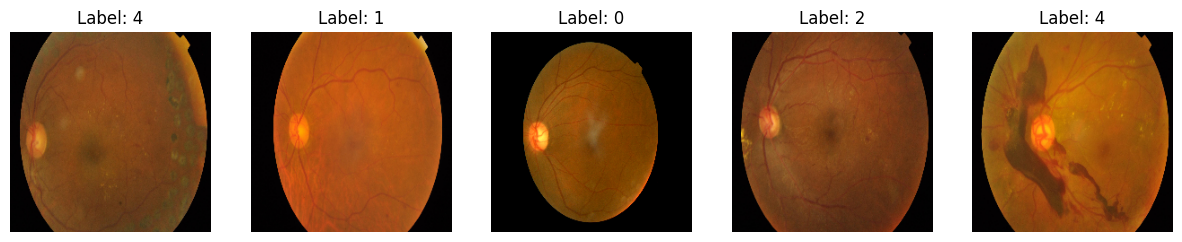

In [10]:
import random

random_indices = random.sample(range(len(X)), 5)
plt.figure(figsize=(15, 8))
for i, index in enumerate(random_indices):
    plt.subplot(1, 5, i + 1)
    plt.imshow(X[index])
    plt.title(f"Label: {y[index]}")
    plt.axis('off')
plt.show()


In [11]:
for subfolder in os.listdir(dataset_path):
    subfolder_path = os.path.join(dataset_path, subfolder)

    if os.path.isdir(subfolder_path):  # Cek apakah benar-benar folder
        count = len([name for name in os.listdir(subfolder_path) if os.path.isfile(os.path.join(subfolder_path, name))])
        print(f'Jumlah gambar pada folder {subfolder}: {count}')

Jumlah gambar pada folder Mild: 370
Jumlah gambar pada folder Moderate: 999
Jumlah gambar pada folder No_DR: 1805
Jumlah gambar pada folder Proliferate_DR: 295
Jumlah gambar pada folder Severe: 193


## Splitting Data

In [12]:
X = np.array(X)
y = np.array(y)

X_train, X_remainingdata, y_train, y_remainingdata = train_test_split(X, y, train_size=0.6, random_state=42, stratify=y)
X_valid, X_test, y_valid, y_test = train_test_split(X_remainingdata, y_remainingdata, test_size=0.25, random_state=42, stratify=y_remainingdata)

print(f"Ukuran data training: {len(X_train)}")
print(f"Ukuran data validasi: {len(X_valid)}")
print(f"Ukuran data testing: {len(X_test)}")


Ukuran data training: 2197
Ukuran data validasi: 1098
Ukuran data testing: 367


In [13]:
print(X_train.shape)

(2197, 224, 224, 3)


In [14]:
from collections import Counter
print("\nDistribusi kelas :")
print("Training:", Counter(y_train))
print("Validation:", Counter(y_valid))
print("Testing:", Counter(y_test))


Distribusi kelas :
Training: Counter({0: 1083, 2: 599, 1: 222, 4: 177, 3: 116})
Validation: Counter({0: 541, 2: 300, 1: 111, 4: 88, 3: 58})
Testing: Counter({0: 181, 2: 100, 1: 37, 4: 30, 3: 19})


## Preprocessing Image


In [15]:
def preprocess_image(image):
    # Ekstrak green channel
    green_channel = image[:, :, 1]

    # CLAHE
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    enha = clahe.apply(green_channel)

    # Gaussian Blur
    blurred = cv2.GaussianBlur(enha, (3, 3), sigmaX=0.3, sigmaY=0.3)

    # Konversi kembali ke 3 channel
    processed_image = cv2.merge([blurred, blurred, blurred])

    return processed_image


X_train_processed = np.array([preprocess_image(img) for img in X_train])
X_valid_processed = np.array([preprocess_image(img) for img in X_valid])
X_test_processed = np.array([preprocess_image(img) for img in X_test])

In [16]:
print("Shape X_train_processed:", X_train_processed.shape)
print("Shape X_valid_processed:", X_valid_processed.shape)
print("Shape X_test_processed:", X_test_processed.shape)

Shape X_train_processed: (2197, 224, 224, 3)
Shape X_valid_processed: (1098, 224, 224, 3)
Shape X_test_processed: (367, 224, 224, 3)


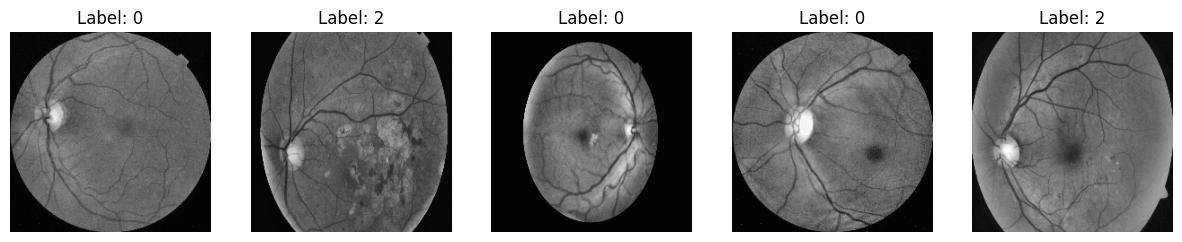

In [17]:
# Displaying sample preprocessed images
random_indices = random.sample(range(len(X_train_processed)), 5)
plt.figure(figsize=(15, 8))
for i, index in enumerate(random_indices):
    plt.subplot(1, 5, i + 1)
    plt.imshow(X_train_processed[index])
    plt.title(f"Label: {y_train[index]}")
    plt.axis('off')
plt.show()


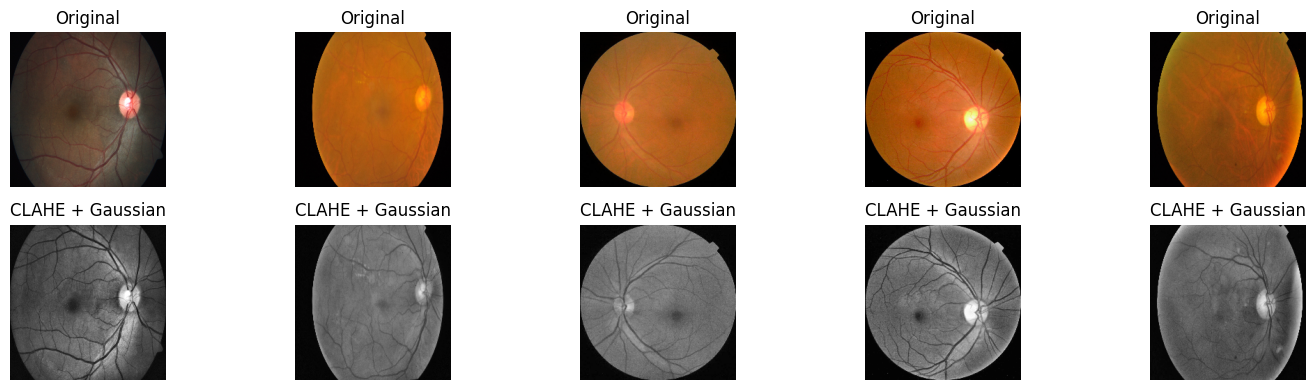

In [18]:
n_samples = 5
sample_indices = np.random.choice(len(X), n_samples, replace=False)
sample_originals = [X[i] for i in sample_indices]
sample_processed = [preprocess_image(img) for img in sample_originals]

# Tampilkan hasil
plt.figure(figsize=(15, 4))
for i in range(n_samples):
    # Gambar original (atas)
    plt.subplot(2, n_samples, i + 1)
    #original_rgb = cv2.cvtColor(sample_originals[i], cv2.COLOR_BGR2RGB)
    plt.imshow(sample_originals[i])
    plt.title("Original")
    plt.axis("off")

    # Gambar hasil preprocess (bawah)
    plt.subplot(2, n_samples, i + 1 + n_samples)
    plt.imshow(sample_processed[i], cmap='gray')  # bisa juga hapus cmap biar full RGB grayscale
    plt.title("CLAHE + Gaussian")
    plt.axis("off")

plt.tight_layout()
plt.show()


## Build Model ResNet50

In [19]:
n_class = 5

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224,224,3))
for layer in base_model.layers :
    layer.trainable = False

x = GlobalAveragePooling2D()(base_model.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(n_class, activation='softmax')(x)

adam = Adam(lr=1e-4)
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy', Recall(), Precision()])

In [20]:
from keras.utils import to_categorical

y_train_one_hot = to_categorical(y_train, num_classes=n_class)
y_valid_one_hot = to_categorical(y_valid, num_classes=n_class)
y_test_one_hot = to_categorical(y_test, num_classes=n_class )

In [21]:
print(X_train_processed.shape)
print(y_train_one_hot.shape)
print(X_valid_processed.shape)
print(y_valid_one_hot.shape)

(2197, 224, 224, 3)
(2197, 5)
(1098, 224, 224, 3)
(1098, 5)


In [22]:
es = EarlyStopping(monitor='val_loss', patience=5)
rlr = ReduceLROnPlateau(monitor='val_loss',
    factor=0.5,
    patience=3,
    verbose=1,
    min_lr=1e-7)

In [23]:
history = model.fit(X_train_processed,y_train_one_hot, epochs=32, batch_size=8, validation_data=(X_valid_processed, y_valid_one_hot), callbacks=[es, rlr])

Epoch 1/32
275/275 [==============================] - 34s 71ms/step - loss: 0.9334 - accuracy: 0.6623 - recall: 0.5435 - precision: 0.7678 - val_loss: 0.7065 - val_accuracy: 0.7377 - val_recall: 0.6767 - val_precision: 0.8015 - lr: 1.0000e-04
Epoch 2/32
275/275 [==============================] - 17s 61ms/step - loss: 0.6959 - accuracy: 0.7346 - recall: 0.6595 - precision: 0.8127 - val_loss: 0.6662 - val_accuracy: 0.7532 - val_recall: 0.6903 - val_precision: 0.8081 - lr: 1.0000e-04
Epoch 3/32
275/275 [==============================] - 17s 62ms/step - loss: 0.6350 - accuracy: 0.7638 - recall: 0.6923 - precision: 0.8257 - val_loss: 0.6302 - val_accuracy: 0.7723 - val_recall: 0.7158 - val_precision: 0.8062 - lr: 1.0000e-04
Epoch 4/32
275/275 [==============================] - 23s 82ms/step - loss: 0.6064 - accuracy: 0.7788 - recall: 0.7082 - precision: 0.8312 - val_loss: 0.6175 - val_accuracy: 0.7823 - val_recall: 0.7240 - val_precision: 0.8154 - lr: 1.0000e-04
Epoch 5/32
275/275 [========

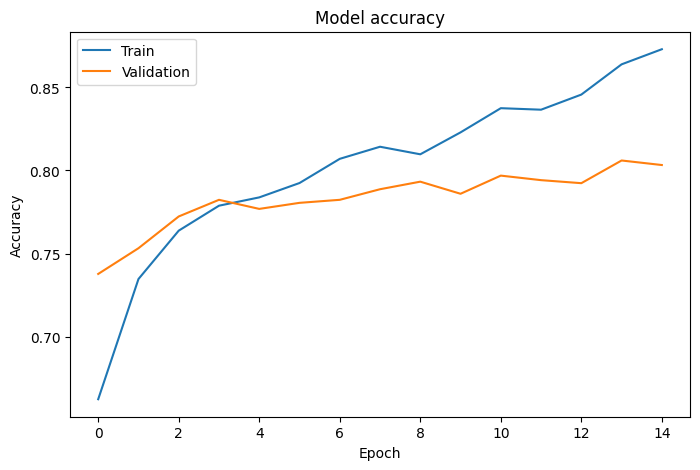

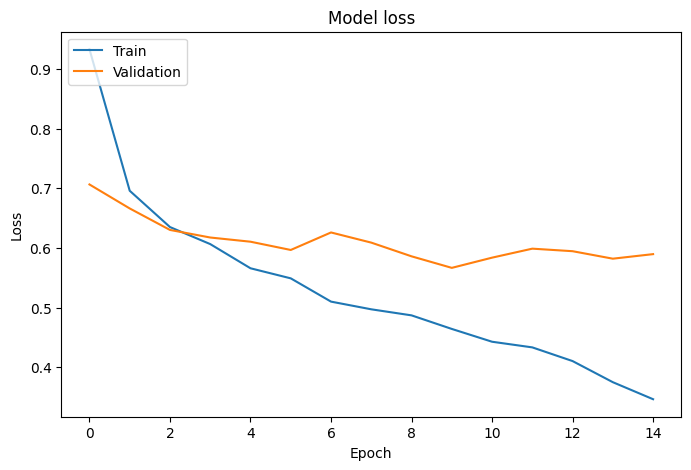

In [24]:
# Plot training & validation accuracy values
plt.figure(figsize=(8, 5))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


69/69 [==============================] - 7s 86ms/step


<Figure size 700x600 with 0 Axes>

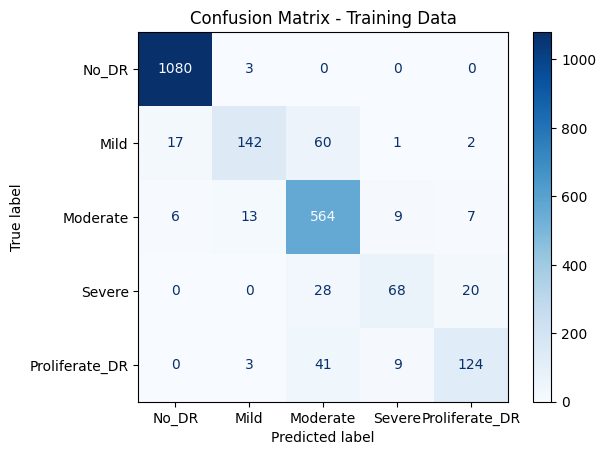

Classification Report (Train):
                precision    recall  f1-score   support

         No_DR       0.98      1.00      0.99      1083
          Mild       0.88      0.64      0.74       222
      Moderate       0.81      0.94      0.87       599
        Severe       0.78      0.59      0.67       116
Proliferate_DR       0.81      0.70      0.75       177

      accuracy                           0.90      2197
     macro avg       0.85      0.77      0.80      2197
  weighted avg       0.90      0.90      0.90      2197



In [25]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
y_train_true = np.argmax(y_train_one_hot, axis=1)

# Prediksi data training
y_train_pred_probs = model.predict(X_train_processed)
y_train_pred = np.argmax(y_train_pred_probs, axis=1)

# Confusion matrix train
cm_train = confusion_matrix(y_train_true, y_train_pred)
labels = ['No_DR', 'Mild', 'Moderate', 'Severe', 'Proliferate_DR']

# Plot
plt.figure(figsize=(7,6))
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=labels)
disp_train.plot(cmap=plt.cm.Blues, values_format='d')
plt.title('Confusion Matrix - Training Data')
plt.show()

# Classification Report
print("Classification Report (Train):")
print(classification_report(y_train_true, y_train_pred, target_names=labels))

## Test Evaluate

In [26]:
print("Shape y_test_one_hot:", y_test_one_hot.shape)
print("Shape x_test_processed:", X_test_processed.shape)


Shape y_test_one_hot: (367, 5)
Shape x_test_processed: (367, 224, 224, 3)


In [27]:
y_true = np.argmax(y_test_one_hot, axis=1) 
y_pred = model.predict(X_test_processed)  
y_pred = np.argmax(y_pred, axis=1)  

12/12 [==============================] - 1s 94ms/step


In [28]:
print(model.evaluate(X_test_processed, y_test_one_hot))

12/12 [==============================] - 1s 86ms/step - loss: 0.6144 - accuracy: 0.7793 - recall: 0.7602 - precision: 0.8182
[0.6144295930862427, 0.779291570186615, 0.7602179646492004, 0.8181818127632141]


12/12 [==============================] - 1s 84ms/step


<Figure size 700x600 with 0 Axes>

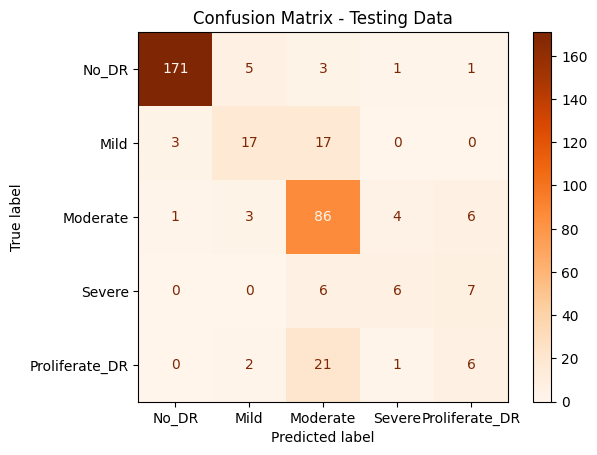

Classification Report (Test):
                precision    recall  f1-score   support

         No_DR       0.98      0.94      0.96       181
          Mild       0.63      0.46      0.53        37
      Moderate       0.65      0.86      0.74       100
        Severe       0.50      0.32      0.39        19
Proliferate_DR       0.30      0.20      0.24        30

      accuracy                           0.78       367
     macro avg       0.61      0.56      0.57       367
  weighted avg       0.77      0.78      0.77       367



In [29]:
# Konversi one-hot label test ke label asli
y_test_true = np.argmax(y_test_one_hot, axis=1)

# Prediksi data test
y_test_pred_probs = model.predict(X_test_processed)
y_test_pred = np.argmax(y_test_pred_probs, axis=1)

# Confusion matrix test
cm_test = confusion_matrix(y_test_true, y_test_pred)

# Plot
plt.figure(figsize=(7,6))
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=labels)
disp_test.plot(cmap=plt.cm.Oranges, values_format='d')
plt.title('Confusion Matrix - Testing Data')
plt.show()

# Classification Report
print("Classification Report (Test):")
print(classification_report(y_test_true, y_test_pred, target_names=labels))


In [30]:
macro_f1 = f1_score(y_true, y_pred, average='macro')
print(f'Macro F1 Score: ', macro_f1)

Macro F1 Score:  0.5714436712779246


In [31]:
from glob import glob
image_paths = glob("test_images/*.png") + glob("test_images/*.jpg")
random.shuffle(image_paths)
image_paths = image_paths[:10]  # Increased sample size for better analysis
print(f"Ditemukan {len(image_paths)} gambar fundus")

Ditemukan 10 gambar fundus


1/1 [==============================] - 0s 24ms/step


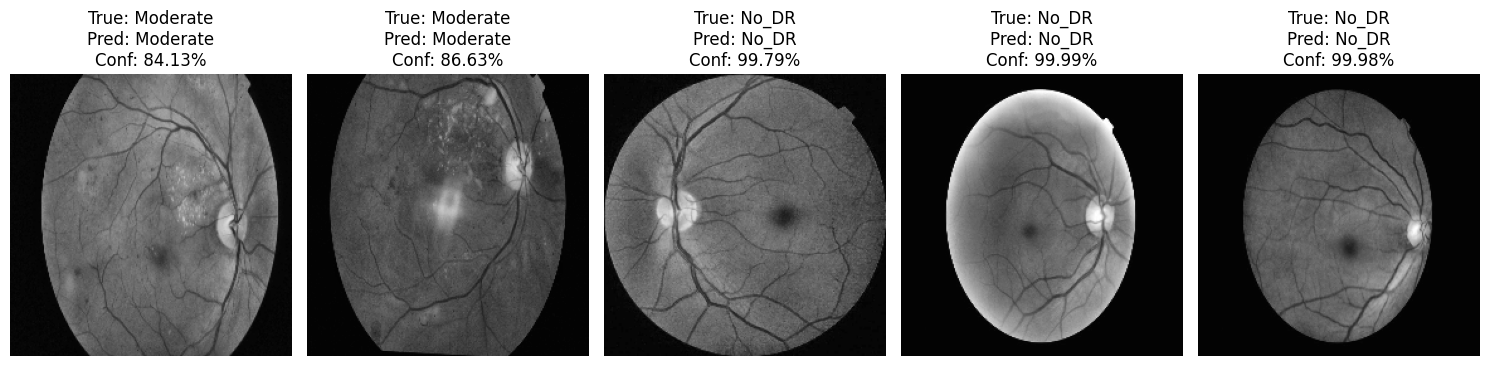

In [32]:
# Pilih beberapa sample acak dari data test
sample_indices = random.sample(range(len(X_test_processed)), 5)
sample_images = X_test_processed[sample_indices]
sample_true_labels = y_test_true[sample_indices]
sample_pred_probs = model.predict(sample_images)
sample_pred_labels = np.argmax(sample_pred_probs, axis=1)
sample_confidences = np.max(sample_pred_probs, axis=1)

# Visualisasi hasil prediksi
plt.figure(figsize=(15, 5))
for i in range(5):
    img = sample_images[i]
    plt.subplot(1, 5, i + 1)
    plt.imshow(img)
    plt.title(f"True: {labels[sample_true_labels[i]]}\nPred: {labels[sample_pred_labels[i]]}\nConf: {sample_confidences[i]:.2%}")
    plt.axis("off")

plt.tight_layout()
plt.show()


12/12 [==============================] - 1s 84ms/step


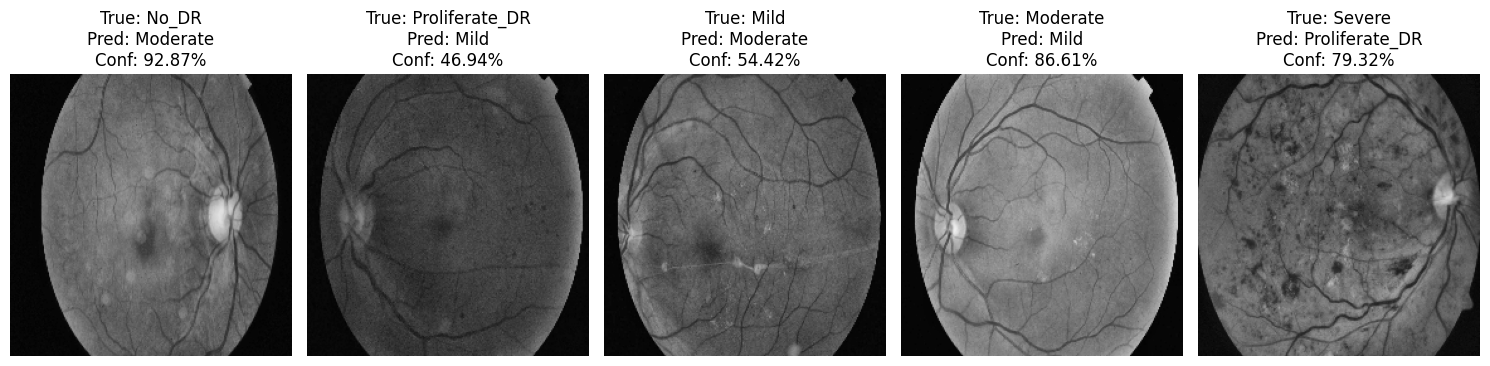

In [33]:
import numpy as np
import matplotlib.pyplot as plt

# Dapatkan prediksi dari seluruh data test
y_pred_probs = model.predict(X_test_processed)
y_pred_labels = np.argmax(y_pred_probs, axis=1)

# Simpan kesalahan prediksi
misclassified_indices = np.where(y_pred_labels != y_test_true)[0]

# Dictionary untuk menyimpan satu contoh kesalahan per kelas
error_examples = {}

for idx in misclassified_indices:
    true_label = y_test_true[idx]
    pred_label = y_pred_labels[idx]

    # Hanya simpan satu contoh per kelas
    if true_label not in error_examples:
        error_examples[true_label] = {
            "image": X_test_processed[idx],
            "true": true_label,
            "pred": pred_label,
            "conf": np.max(y_pred_probs[idx])
        }

    # Berhenti kalau semua kelas sudah punya contoh
    if len(error_examples) == len(labels):
        break

# Visualisasi
plt.figure(figsize=(15, 8))
for i, class_id in enumerate(error_examples):
    example = error_examples[class_id]
    img = example["image"]
    true_label = labels[example["true"]]
    pred_label = labels[example["pred"]]
    conf = example["conf"]

    plt.subplot(1, len(error_examples), i + 1)
    plt.imshow(img)
    plt.title(f"True: {true_label}\nPred: {pred_label}\nConf: {conf:.2%}")
    plt.axis("off")

plt.tight_layout()
plt.show()


12/12 [==============================] - 1s 81ms/step


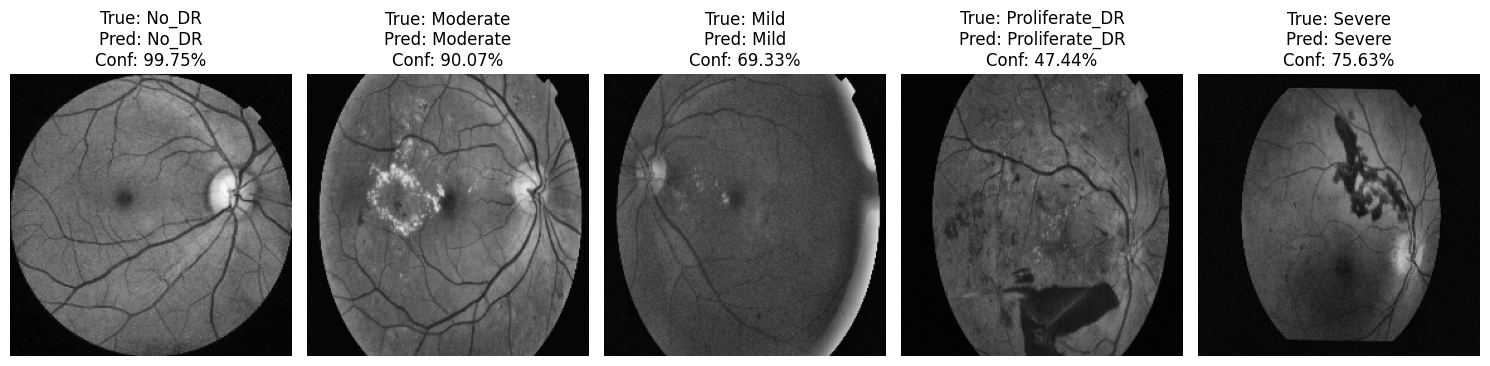

In [34]:


# Dapatkan prediksi dari seluruh data test
y_pred_probs = model.predict(X_test_processed)
y_pred_labels = np.argmax(y_pred_probs, axis=1)

# Simpan prediksi yang benar
correct_indices = np.where(y_pred_labels == y_test_true)[0]

# Dictionary untuk simpan satu contoh benar per kelas
correct_examples = {}

for idx in correct_indices:
    true_label = y_test_true[idx]
    
    # Hanya ambil 1 contoh per kelas
    if true_label not in correct_examples:
        correct_examples[true_label] = {
            "image": X_test_processed[idx],
            "true": true_label,
            "pred": y_pred_labels[idx],
            "conf": np.max(y_pred_probs[idx])
        }

    # Stop kalau semua kelas sudah ada
    if len(correct_examples) == len(labels):
        break

# Visualisasi
plt.figure(figsize=(15, 8))
for i, class_id in enumerate(correct_examples):
    example = correct_examples[class_id]
    img = example["image"]
    true_label = labels[example["true"]]
    pred_label = labels[example["pred"]]
    conf = example["conf"]

    plt.subplot(1, len(correct_examples), i + 1)
    plt.imshow(img)
    plt.title(f"True: {true_label}\nPred: {pred_label}\nConf: {conf:.2%}")
    plt.axis("off")

plt.tight_layout()
plt.show()


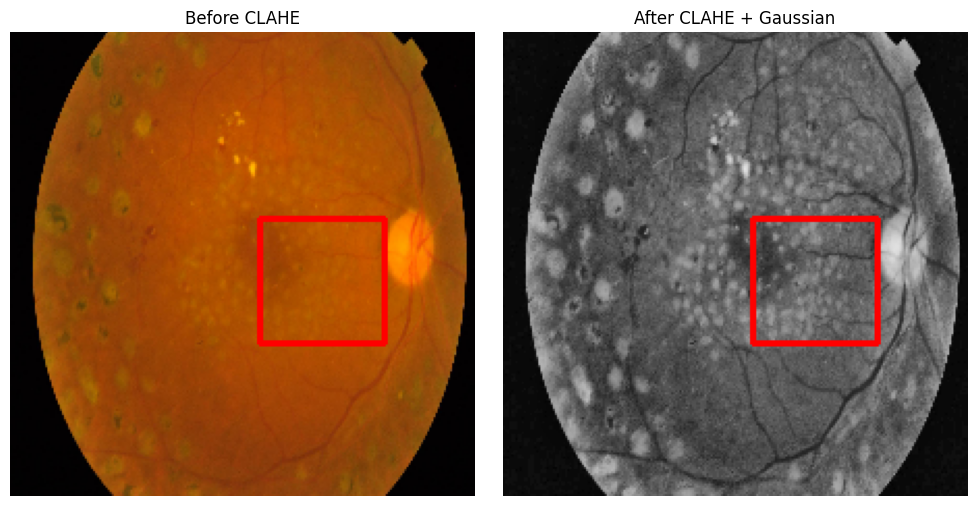

In [35]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

# Fungsi preprocessing: CLAHE + Gaussian Blur
def preprocess_image(image):
    green_channel = image[:, :, 1]

    # CLAHE
    clahe = cv2.createCLAHE(clipLimit=4.0, tileGridSize=(8,8))
    enha = clahe.apply(green_channel)

    # Gaussian Blur
    blurred = cv2.GaussianBlur(enha, (3, 3), sigmaX=0.3, sigmaY=0.3)

    return blurred  # Hasil 1 channel (grayscale)

# Load gambar fundus (ubah path sesuai gambarmu)
img_path = 'colored_images/Severe/4d9fc85a8259.png'
img_before = cv2.imread(img_path)

# Pastikan gambar berhasil dimuat
if img_before is None:
    print("Gambar tidak ditemukan. Cek path file-nya.")
else:
    img_before = cv2.cvtColor(img_before, cv2.COLOR_BGR2RGB)  # convert ke RGB

    # Lakukan preprocessing
    img_after = preprocess_image(img_before)

    # Tentukan area penting yang mau ditandai (x, y, w, h)
    highlight_area = (120, 90, 60, 60)  # bisa kamu ubah sesuai kebutuhan
    x, y, w, h = highlight_area

    # Buat salinan gambar dan tambahkan bingkai merah
    img_before_box = img_before.copy()
    img_after_box = cv2.cvtColor(img_after, cv2.COLOR_GRAY2RGB)  # biar bisa dikasih rectangle warna
    cv2.rectangle(img_before_box, (x, y), (x+w, y+h), (255, 0, 0), 2)  # merah
    cv2.rectangle(img_after_box, (x, y), (x+w, y+h), (255, 0, 0), 2)

    # Visualisasi side-by-side
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(img_before_box)
    plt.title('Before CLAHE')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(img_after_box)
    plt.title('After CLAHE + Gaussian')
    plt.axis('off')

    plt.tight_layout()
    plt.show()


# EXPLAINABILTY MODEL

In [37]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [38]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # Buat model grad model
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Rekam gradient
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    # Gradien terhadap output conv terakhir
    grads = tape.gradient(class_channel, conv_outputs)

    # Global average pooling pada gradien
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Kalikan gradien dengan output conv
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # Normalisasi heatmap
    heatmap = tf.maximum(heatmap, 0) / tf.reduce_max(heatmap)
    return heatmap.numpy()

In [42]:
def display_gradcam(img, heatmap, alpha=0.4):
    # Resize heatmap sesuai ukuran gambar
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

    # Apply colormap
    heatmap_color = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)

    # Normalisasi gambar asli
    if img.dtype != np.uint8:
        img = (img * 255).astype(np.uint8)

    # Gabungkan heatmap dengan gambar asli
    superimposed_img = cv2.addWeighted(heatmap_color, alpha, img, 1 - alpha, 0)

    return superimposed_img


1/1 [==============================] - 0s 29ms/step


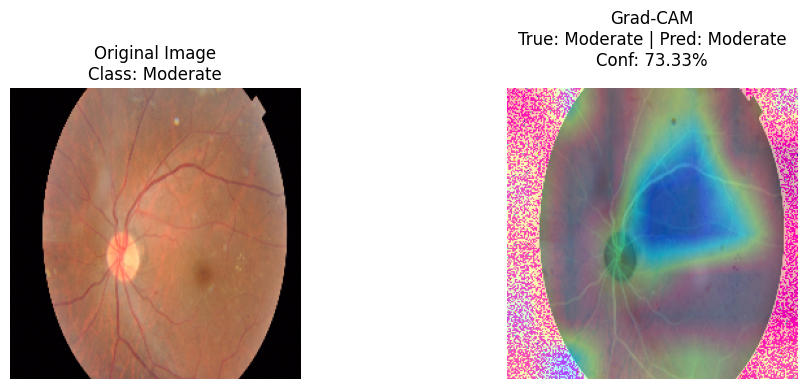

In [81]:
index = 19

# Ambil gambar yang sudah diproses
img = X_test_processed[index]
img_input = np.expand_dims(img, axis=0)

# Nama layer terakhir convolusi
last_conv_layer_name = "conv5_block3_out"

# Grad-CAM heatmap
heatmap = make_gradcam_heatmap(img_input, model, last_conv_layer_name)

# Ambil gambar asli (belum diproses)
original_img = X_test[index]
original_img_uint8 = (original_img * 255).astype(np.uint8)

# Prediksi
pred_probs = model.predict(img_input)
pred_label = labels[np.argmax(pred_probs)]
conf = np.max(pred_probs) * 100

# Label asli
true_label = labels[y_test_true[index]]

# Plot
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(original_img)
plt.title("Original Image\nClass: Moderate")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(display_gradcam(original_img_uint8, heatmap, alpha=0.3))
plt.title(f"Grad-CAM\nTrue: {true_label} | Pred: {pred_label}\nConf: {conf:.2f}%", y=1.05)
plt.axis("off")

plt.tight_layout()
plt.subplots_adjust(wspace=0.05) 
plt.show()


1/1 [==============================] - 0s 27ms/step


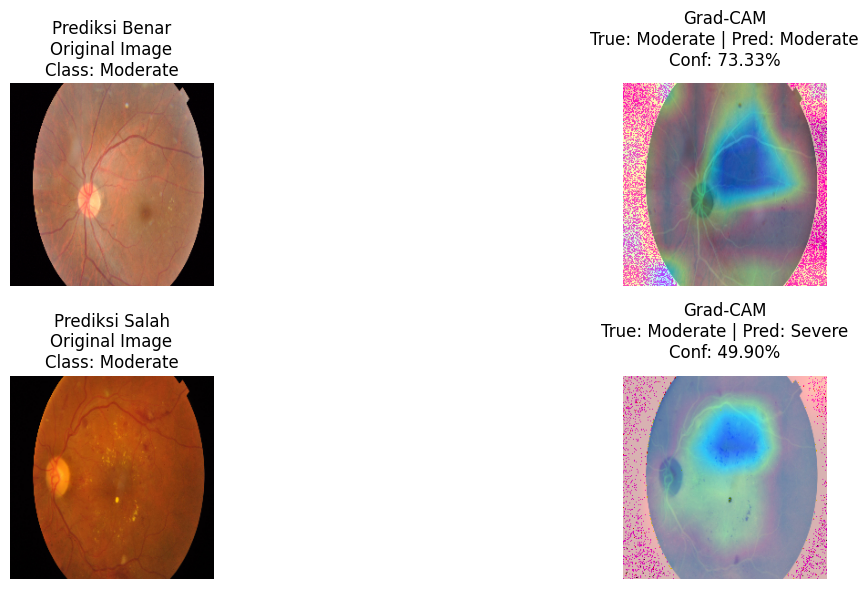

In [102]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Fungsi Grad-CAM (pastikan kamu sudah punya make_gradcam_heatmap & display_gradcam)
# ...

# Pilih indeks untuk contoh benar dan salah
# Gantilah index ini sesuai data kamu
correct_idx = 19  # Prediksi benar
wrong_idx = 342 # Prediksi salah

# List index dan label
indices = [correct_idx, wrong_idx]
titles = ["Prediksi Benar", "Prediksi Salah"]

# Plot
plt.figure(figsize=(12, 6))

for i, idx in enumerate(indices):
    # Gambar & input
    img = X_test_processed[idx]
    img_input = np.expand_dims(img, axis=0)
    original_img = X_test[idx]
    original_img_uint8 = (original_img * 255).astype(np.uint8)

    # Grad-CAM
    heatmap = make_gradcam_heatmap(img_input, model, "conv5_block3_out")
    gradcam_output = display_gradcam(original_img_uint8, heatmap, alpha=0.3)

    # Prediksi dan label asli
    pred_probs = model.predict(img_input)
    pred_label = labels[np.argmax(pred_probs)]
    conf = np.max(pred_probs) * 100
    true_label = labels[y_test_true[idx]]

    # Plot original
    plt.subplot(2, 2, 1 + i * 2)
    plt.imshow(original_img)
    plt.title(f"{titles[i]}\nOriginal Image\nClass: {true_label}")
    plt.axis("off")

    # Plot gradcam
    plt.subplot(2, 2, 2 + i * 2)
    plt.imshow(gradcam_output)
    plt.title(f"Grad-CAM\nTrue: {true_label} | Pred: {pred_label}\nConf: {conf:.2f}%", y=1.05)
    plt.axis("off")

plt.tight_layout()
plt.subplots_adjust(wspace=0.1)
plt.show()
